In [1]:
import torch
import numpy as np
import pandas as pd
from itertools import chain
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F
import spacy
from spacy import displacy
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
df=pd.read_csv('/content/drive/MyDrive/NLP Project/ner_dataset.csv',encoding="unicode_escape")
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [3]:
df.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

In [ ]:
df['Sentence #'].unique

<bound method Series.unique of 0          Sentence: 1
1                  NaN
2                  NaN
3                  NaN
4                  NaN
              ...     
1048570            NaN
1048571            NaN
1048572            NaN
1048573            NaN
1048574            NaN
Name: Sentence #, Length: 1048575, dtype: object>

In [ ]:
df['Tag'].unique

<bound method Series.unique of 0          O
1          O
2          O
3          O
4          O
          ..
1048570    O
1048571    O
1048572    O
1048573    O
1048574    O
Name: Tag, Length: 1048575, dtype: object>

In [ ]:
df['Word'].nunique

<bound method IndexOpsMixin.nunique of 0              Thousands
1                     of
2          demonstrators
3                   have
4                marched
               ...      
1048570             they
1048571        responded
1048572               to
1048573              the
1048574           attack
Name: Word, Length: 1048575, dtype: object>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [ ]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 1,the,NN,O
freq,1,52573,145807,887908


So based on describe we understand there are 35178 unique words ,42 unique POS and 17 unique Tags are there

In [ ]:
df.POS.value_counts()

NN      145807
NNP     131426
IN      120996
DT       98454
JJ       78412
NNS      75840
.        47831
VBD      39379
,        32757
VBN      32328
VBZ      24960
CD       24695
VB       24211
CC       23716
TO       23061
RB       20252
VBG      19125
VBP      16158
PRP      13318
POS      11257
PRP$      8655
MD        6973
``        3728
WDT       3698
JJS       3034
JJR       2967
WP        2542
NNPS      2521
RP        2490
WRB       2184
$         1149
RBR       1055
:          795
RRB        679
LRB        678
EX         663
RBS        296
;          214
PDT        147
WP$         99
UH          24
FW           1
Name: POS, dtype: int64

we will create token for iterables

In [4]:
def get_dict_map(data,token_or_tag):
  tok2idx={}
  idx2tok={}
  if token_or_tag=='token':
    vocab=list(set(df['Word'].to_list()))
  else :
    vocab=list(set(df['Tag'].to_list()))
  idx2tok={idx:tok for idx,tok in enumerate(vocab)}
  tok2idx={tok:idx for idx,tok in enumerate(vocab)}
  return tok2idx,idx2tok
token2idx,idx2token=get_dict_map(df,'token')
tag2idx,idx2tag=get_dict_map(df,'tag')

In [5]:
token2idx

{'burst': 0,
 '400-meter': 1,
 'pretense': 2,
 'Citroen': 3,
 'Chen': 4,
 'prayerful': 5,
 'Lancaster': 6,
 '07-Jun': 7,
 'ounce': 8,
 '91': 9,
 'chaired': 10,
 'Seyranlioglu': 11,
 'ghost': 12,
 'Jianzhong': 13,
 'German-owned': 14,
 'Shyam': 15,
 'Castro': 16,
 'NATO-EU': 17,
 'SARS': 18,
 'spur': 19,
 'forensics': 20,
 'Bear': 21,
 'Palestine': 22,
 'congresswoman': 23,
 'el-Hadary': 24,
 'campaigning': 25,
 'ten-year': 26,
 'We': 27,
 'Boulder': 28,
 'Mekorot': 29,
 'sculptures': 30,
 'Six-thousand': 31,
 'reminded': 32,
 'India-U.S.': 33,
 'tentative': 34,
 'Mughal': 35,
 'careers': 36,
 'Perry': 37,
 'recalling': 38,
 'abductees': 39,
 'Galam': 40,
 'superintendent': 41,
 'visits': 42,
 'Sainct': 43,
 'eliminate': 44,
 'T-shirt': 45,
 'briefly': 46,
 'capsize': 47,
 'scope': 48,
 'traverse': 49,
 'Benshoofin': 50,
 'preserve': 51,
 'freed': 52,
 'brightens': 53,
 'mane': 54,
 'Sagaing': 55,
 'Haq': 56,
 'Kars-Akhalkalaki': 57,
 'Roshan': 58,
 'XDR-TB': 59,
 'SWALLOW': 60,
 'Turni

In [ ]:
tag2idx

{'O': 0,
 'B-per': 1,
 'B-geo': 2,
 'B-gpe': 3,
 'B-art': 4,
 'I-art': 5,
 'B-nat': 6,
 'I-gpe': 7,
 'I-org': 8,
 'I-per': 9,
 'I-nat': 10,
 'B-eve': 11,
 'I-eve': 12,
 'I-tim': 13,
 'B-tim': 14,
 'I-geo': 15,
 'B-org': 16}

In [ ]:
idx2tag

{0: 'O',
 1: 'B-per',
 2: 'B-geo',
 3: 'B-gpe',
 4: 'B-art',
 5: 'I-art',
 6: 'B-nat',
 7: 'I-gpe',
 8: 'I-org',
 9: 'I-per',
 10: 'I-nat',
 11: 'B-eve',
 12: 'I-eve',
 13: 'I-tim',
 14: 'B-tim',
 15: 'I-geo',
 16: 'B-org'}

In [6]:
df['Word_idx']=df['Word'].map(token2idx)
df['tag_idx']=df['Tag'].map(tag2idx)
df_fillna=df.fillna(method='ffill',axis=0)#ffill: propagate last valid observation forward to next valid.
                                          #bfill: use next valid observation to fill gap..
df_group = df_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'tag_idx'].agg(lambda x: list(x))

<ipython-input-6-1827d40b3556>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_group = df_fillna.groupby(


In [7]:
df_group.head(5)

,Sentence #,Word,POS,Tag,Word_idx,tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[23703, 31202, 7334, 1585, 20878, 2796, 1214, ...","[15, 15, 15, 15, 15, 15, 13, 15, 15, 15, 15, 1..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[14581, 15761, 34959, 13528, 10346, 10010, 216...","[14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[32009, 23241, 14892, 18841, 1090, 3493, 24568...","[15, 15, 6, 15, 15, 15, 15, 15, 13, 15, 15, 15..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[6296, 28727, 35036, 7082, 32212, 12269, 4251,...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[8567, 21459, 25720, 30482, 1746, 12472, 11861...","[13, 15, 15, 7, 12, 15, 6, 15, 13, 15, 14, 15,..."


In [ ]:
tag2idx['O']

0

In [ ]:

class MyDataset(Dataset):
    def __init__(self, tokens, tags):
        self.tokens = tokens
        self.tags = tags

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, index):
        return self.tokens[index], self.tags[index]

def collate_fn(batch):
    tokens, tags = zip(*batch)
    tokens = pad_sequence(tokens, batch_first=True)
    tags = pad_sequence(tags, batch_first=True)
    return tokens, tags

def get_train_test(data_group, data, train_ratio=0.8, test_ratio=0.2, random_seed=42):
    # Get max token and tag length
    n_token = len(list(set(data['Word'].tolist())))
    n_tag = len(list(set(data['Tag'].tolist())))

    # Pad tokens (X var)
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = [torch.tensor(seq) for seq in tokens]
    pad_tokens = pad_sequence(pad_tokens, batch_first=True, padding_value=n_token - 1)

    # Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['tag_idx'].tolist()
    pad_tags = [torch.tensor(seq) for seq in tags]
    pad_tags = pad_sequence(pad_tags, batch_first=True, padding_value=tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [torch.nn.functional.one_hot(seq, num_classes=n_tags) for seq in pad_tags]

    # Split train, test, and validation set
    tokens_train, tokens_test, tags_train, tags_test = train_test_split(
        pad_tokens, pad_tags, train_size=train_ratio, test_size=test_ratio, random_state=random_seed)


    train_dataset = MyDataset(tokens_train, tags_train)

    test_dataset = MyDataset(tokens_test, tags_test)

    train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)

    test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)

    return train_loader,  test_loader
    #return train_dataset,val_dataset,test_dataset
train_loader,test_loader = get_train_test(df_group, df)


In [ ]:
d=[len(s) for s in df_group['Word_idx'].tolist()]
max(d)

104

In [ ]:
df_group.columns

Index(['Sentence #', 'Word', 'POS', 'Tag', 'Word_idx', 'tag_idx'], dtype='object')

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
torch.manual_seed(1)
torch.cuda.manual_seed(13)

class BiLSTM_LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(BiLSTM_LSTM_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.2)
        self.lstm = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        bilstm_out, _ = self.bilstm(embeddings)
        lstm_out, _ = self.lstm(bilstm_out)
        output = self.fc(lstm_out)
        return output
input_dim = len(list(set(df['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in df_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

model = BiLSTM_LSTM_Model(input_dim, output_dim, input_length, n_tags)

model.to(device)





BiLSTM_LSTM_Model(
  (embedding): Embedding(35179, 64)
  (bilstm): LSTM(64, 104, batch_first=True, dropout=0.2, bidirectional=True)
  (lstm): LSTM(208, 104, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=104, out_features=17, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_values = []
accuracy_values = []
test_loss=[]
test_acc=[]
for epoch in range(100):
  model.train()
  total_loss = 0
  correct = 0
  total = 0
  total_loss_t=0
  correct_t=0
  total_t=0
  for X, y in train_loader:
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    outputs = model(X).to(device)
    loss = loss_fn(outputs.transpose(1, 2), torch.argmax(y, dim=2))
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=2)
    correct += (predicted == torch.argmax(y, dim=2)).sum().item()
    total += y.size(0) * y.size(1)

  epoch_loss = total_loss / len(train_loader)
  epoch_accuracy = correct / total
  loss_values.append(epoch_loss)
  accuracy_values.append(epoch_accuracy)
  model.eval()
  with torch.inference_mode():
    for X, y in test_loader:
      X = X.to(device)
      y = y.to(device)
      t_outputs = model(X).to(device)
      t_loss = loss_fn(t_outputs.transpose(1, 2), torch.argmax(y, dim=2))
      total_loss_t += t_loss.item()
      _, predicted = torch.max(t_outputs.data, dim=2)
      correct_t += (predicted == torch.argmax(y, dim=2)).sum().item()
      total_t += y.size(0) * y.size(1)
  te_loss = total_loss_t / len(test_loader)
  epo_accuracy = correct_t / total_t
  loss_values.append(epoch_loss)
  accuracy_values.append(epoch_accuracy)
  test_loss.append(te_loss)
  test_acc.append(epo_accuracy)
  print(f'Epoch: {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.4f} | Test Loss :{te_loss} | Test Accuracy : {epo_accuracy}')

Epoch: 1 | Loss: 0.1161 | Accuracy: 0.9741 | Test Loss :0.053660460983713465 | Test Accuracy : 0.9857292936421377
Epoch: 2 | Loss: 0.0396 | Accuracy: 0.9890 | Test Loss :0.0343031991366297 | Test Accuracy : 0.9903475251812408
Epoch: 3 | Loss: 0.0272 | Accuracy: 0.9920 | Test Loss :0.02971008837223053 | Test Accuracy : 0.9913439484827099
Epoch: 4 | Loss: 0.0216 | Accuracy: 0.9934 | Test Loss :0.027457699027533332 | Test Accuracy : 0.9918782478988901
Epoch: 5 | Loss: 0.0176 | Accuracy: 0.9946 | Test Loss :0.02706607129735251 | Test Accuracy : 0.9922180743568358
Epoch: 6 | Loss: 0.0146 | Accuracy: 0.9955 | Test Loss :0.027514913032452265 | Test Accuracy : 0.992176974401745
Epoch: 7 | Loss: 0.0120 | Accuracy: 0.9963 | Test Loss :0.029685685594255724 | Test Accuracy : 0.9924325960736511
Epoch: 8 | Loss: 0.0097 | Accuracy: 0.9970 | Test Loss :0.030683969091624023 | Test Accuracy : 0.9919825014435106
Epoch: 9 | Loss: 0.0079 | Accuracy: 0.9976 | Test Loss :0.03298142625639836 | Test Accuracy :

In [ ]:
len(accuracy_values)

200

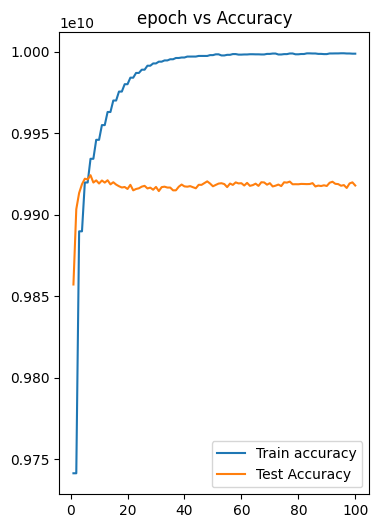

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(4,6))
epoch=[i for i in range(1,101)]
accuracy_values=[i*100 for i in accuracy_values][:100]
test_acc=[i*100 for i in test_acc]
plt.plot(epoch,accuracy_values,label="Train accuracy")
plt.plot(epoch,test_acc,label='Test Accuracy')
plt.title('epoch vs Accuracy')
plt.legend()
plt.show()

In [ ]:

nlp = spacy.load('en_core_web_sm')

def visualize_entities(text, entities):
    # Create a SpaCy Doc object from the text
    doc = nlp(text)

    # Create a list of Span objects for entity spans and labels
    spans = []
    for start, end, label in entities:
        span = doc.char_span(start, end, label=label)
        if span is not None:
            spans.append(span)

    # Render the visualization
    displacy.render(doc, style='ent', jupyter=True)

    # Render the visualization
    #displacy.render(doc, style='ent', jupyter=True)

# Example usage
text = """AI-based machine learning techniques are going beyond the cloud-based data center, as processing of vital IoT sensor data moves much closer to where the data first resides. The move will be enabled by new artificial intelligence (AI)-equipped chips."""
entities = [(0, 20, 'ORG'), (54, 68, 'LOC'), (79, 103, 'TECH')]
visualize_entities(text, entities)

In [ ]:
def preprocess_text(text):
    # Apply preprocessing steps (e.g., tokenization, encoding) to the input text
    # Here's a simple example using whitespace tokenization:
    tokens = text.split()
    preprocessed_text = " ".join(tokens)
    return preprocessed_text

def convert_text_to_input(text):
    # Convert the preprocessed text to numerical representation (e.g., tensors)
    # Here's a simple example using one-hot encoding:
    encoded_text = [ord(c) for c in text]
    input_data = torch.tensor(encoded_text).unsqueeze(0)
    return input_data

def decode_named_entities(predictions):
    # Decode the predicted labels to named entities
    entities = []
    start_idx = None
    label = None
    for i, pred_label in enumerate(predictions):
        if pred_label == 1 and start_idx is None:
            start_idx = i
            label = pred_label
        elif pred_label == 0 and start_idx is not None:
            entities.append((start_idx, i, label))
            start_idx = None
            label = None
    if start_idx is not None:
        entities.append((start_idx, len(predictions), label))
    return entities



In [ ]:
def predict_entities(text, model):
    # Preprocess the text
    preprocessed_text = preprocess_text(text)

    # Convert the preprocessed text to numerical representation
    input_data = convert_text_to_input(preprocessed_text).to(device)
    #print(input_data)

    # Set the model to evaluation mode
    model.eval().to(device)
    #print(device(model))

    # Forward pass through the model
    with torch.no_grad():
        output = model(input_data).to(device)

    # Get the predicted labels
    predicted_labels = torch.argmax(output, dim=2).squeeze().tolist()

    # Decode the predicted labels to named entities
    entities = decode_named_entities(predicted_labels)

    return entities

# Example usage



In [ ]:
text = """Data privacy and security are crucial aspects of any modern organization. With the increasing digitization of information and the rise of cyber threats, it is essential to have robust mechanisms in place to protect sensitive data. This is particularly important in industries such as healthcare, finance, and e-commerce, where the unauthorized disclosure of personal or financial information can have severe consequences.

One effective approach to ensuring data privacy is the implementation of advanced Natural Language Processing (NLP) techniques for Named Entity Recognition (NER). NER is a subtask of information extraction that aims to identify and classify named entities in text, such as names of people, organizations, locations, dates, and more.

By leveraging NLP NER models, organizations can automatically scan and analyze large volumes of text data to identify and classify sensitive information. For instance, in the healthcare industry, NER models can be trained to recognize and extract medical conditions, treatment names, and patient identifiers from clinical notes and electronic health records. Similarly, in the financial sector, NER models can detect and categorize credit card numbers, bank account details, and financial transactions in unstructured text data.

To develop an accurate and reliable NER model, a combination of machine learning techniques and domain-specific training data is essential. Supervised learning algorithms, such as Bidirectional Long Short-Term Memory (BiLSTM) networks, have shown promising results in NER tasks. These models can learn contextual information from both past and future words in a sentence, enabling them to make accurate predictions about entity boundaries and entity types.

Preprocessing of text data plays a crucial role in NER model training. Steps such as tokenization, word embedding, and encoding are necessary to convert raw text into a format that can be fed into the NER model. Tokenization involves splitting the text into individual words or subword units, while word embedding techniques like Word2Vec or GloVe map these words into continuous vector representations. Encoding converts the input text into numerical tensors that can be processed by the NER model.

Once the NER model is trained and fine-tuned on the specific domain data, it can be used to extract named entities from new, unseen text data. The model predicts the start and end positions of entities along with their corresponding entity labels. Post-processing techniques can then be applied to consolidate and validate the predicted entities, ensuring the accuracy and reliability of the extracted information.

However, it is important to note that NER models are not foolproof and may encounter challenges in certain scenarios. Ambiguous entity mentions, out-of-vocabulary words, and domain-specific jargon can pose difficulties for NER models. Continuous evaluation and refinement of the model through feedback loops and incorporating user annotations can help improve its performance over time.

In conclusion, NLP NER models offer significant potential for enhancing data privacy and security in various industries. By automating the identification and classification of named entities in text data, organizations can strengthen their data protection measures and ensure compliance with privacy regulations. Leveraging advanced machine learning techniques and domain-specific training data, NER models can become invaluable tools in the fight against data breaches and unauthorized access to sensitive information.
"""




#model_1=model_bilstm_lstm.to(device)
entities = predict_entities(text, model)
print(entities)
visualize_entities(text, entities)

[(27, 3562, 1)]


NER from inbuilt libraries

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp("""AI-based machine learning techniques are going beyond the cloud-based data center, as processing of vital IoT sensor data moves much closer to where the data first resides.

The move will be enabled by new artificial intelligence (AI)-equipped chips. These include embedded microcontrollers with narrower memory and power consumption requirements than GPUs (graphical processing units), FPGAs (field-programmable gate arrays) and other specialized IC types first used to answer data scientists’ questions in the cloud data centers of Amazon Web Services, Microsoft and Google.

It was in these clouds that machine learning and related neural network use exploded. But the rise of IoT created a data onslaught that required edge-based machine learning as well.

Now, cloud providers, Internet of Things (IoT) platform makers, and others see benefit in processing data at the edge before turning it over to the cloud for analytics.

Making AI decisions at the edge reduces latency and makes real-time response to sensor data more practical and possible. Still, what people call “edge AI” takes many forms. And how to power it with next-gen IoT presents challenges in terms of presenting good-quality actionable data.

Edge Computing Workloads Grow

Edge-based machine learning could drive significant growth of AI in the IoT market, which Mordor Intelligence estimates will grow at a 27.3% CAGR through to 2026.

That is buttressed by Eclipse Foundation IoT Group research in 2020, which pegged AI at 30% as the most commonly cited edge computing workload among IoT developers.

For many applications, replicating the endless racks of servers that enabled parallel machine learning on the cloud is not an option. IoT edge cases that benefit from local processing are many, and highlighted by varied cases of operations monitoring. The processors, for example, watch events triggered by pressure gauge changes on an oil rig, detection of an anomaly on a distant power line, or captured video surveillance of an issue at a factory.

The last case is one of those most widely pursued. Application of AI that parses image data at the edge has proved a fertile area. But there are many complex processing needs for event processing using IoT device-gathered data.

The Value of Edge Compute

Still, cloud-based IoT analytics will endure, said Steve Conway, senior adviser, Hyperion Research. But the distance data must travel brings processing latency. Moving data to and from a cloud naturally creates lag; the round trip takes time.

“There is something called the speed of light,” Conway quips. “And you cannot exceed it.” As result, a hierarchy of processing is developing on the edge.

Other than devices and board-level implementations, this hierarchy includes IoT gateways and data centers in manufacturing that expand architectural options available for next-generation IoT system development.

In the long view, edge AI architecture is yet another generational shift in data processing  focus  – but a key one, according to Saurabh Mishra, senior manager for product marketing at SAS’s IoT and Edge division.

“There is a progression here,” he said. “At one time, the idea was centralizing your data. You can do that for certain industries and certain use cases – ones where data was already created in a context, such as in a data center,” he said.

It’s not really possible to efficiently – and economically – move that to the cloud for analysis,” Mishra said, who noted that SAS has created validated edge IoT reference architectures on top of which customers can build AI and analytical applications. Striking a balance between cloud and edge AI will be a fundamental requirement, he said.

Finding balance begins with consideration of the amount of data needed to run machine learning models, according to Frédéric Desbiens, program manager, IoT and Edge Computing at the Eclipse Foundation. That is where the new intelligent processors come in.

“AI accelerators at the edge can do local processing before sending the data somewhere else. But, this requires you to think about the functional requirements, including the software stack and storage needed,” Desbiens said.

AI Edge Chip Abundance

The rise of cloud-based machine learning was influenced by the rise of the high-memory bandwidth GPU, often in the form of a NVIDIA semiconductor. That success drew the attention of other chip makers.

In-house AI-specific processors followed from hyperscale cloud-players Google, AWS and Microsoft.

That AI chip battle has been joined by leading lights such as AMD, Intel, Qualcomm, and ARM Technology (which, for its part, last year was acquired by NVIDIA).

In turn, embedded microprocessor and systems-on-a-chip mainstays like Maxim Integrated, NXP Semiconductors, Silicon Labs, STM Microelectronics and others began to focus on adding AI abilities to the edge.

Today,  IoT and edge processing needs have attracted AI chip start-ups that include EdgeQ,  Graphcore, Hailo, Mythic and others. Processing on the edge is constrained. Barriers include memory available, energy consumed and cost, emphasizes Hyperion’s Steve Conway.

“The embedded processors are very important, as energy use is very important,” Conway said. “The GPUs and CPUs are not tiny dies, and GPUs, particularly, use a ton of energy,” he said, referring to the relatively large silicon form factors GPUs and CPUs can take on.

Making Neurals Fit the Part

Data movement is a factor in energy consumption on the edge, advises Kris Ardis, executive director of Maxim Integrated’s microcontroller and software algorithm businesses. Recently, the company released the MAX78000, which pairs a low-power controller with a neural net processor that can run on battery-powered IoT devices.

“If you can do a computation at the very edge, you save bandwidth, and communications power. The challenge is taking the neural net and making it fit in the part,” Ardis said.

Individual IoT devices based on the chip can feed IoT gateways, which also have a useful part to play, combining rollups of data from devices, and further filtering data that may go to the cloud in order to analyze overall operations, he indicated.

Other semiconductor device makers also are adjusting to a trend that sees compute moving nearer to where data is. They are part of the effort to broaden the capabilities of developers, even as their hardware choices grow.

Bill Pearson, vice president of Intel’s IoT group admits there was a time when “the CPU was the answer to all problems.” Trends like edge AI belie that now.

He uses the term “XPU” to represent a variety of chip types that support different uses. But, he adds, the variety should be supported by a single software application programming interface (API).

To aid software developers, Intel recently released Version 2021.2 of the OpenVINO toolkit for inference on edge systems. It provides a, common environment for development among Intel components including CPUs, GPUs, and Movidius Visual Processing Units. As well, Intel offers DevCloud for the Edge software to forecast performance of neural network inference on different Intel hardware, according to Pearson.

The drive to simplify is marked at GPU powerhouse NVIDIA too.

“The industry has to make it easier for people that aren’t AI specialists,” said Justin Boitano, vice president and general manager for Enterprise and Edge Computing, NVIDIA.

That may take the form of NVIDIA Jetson, which includes a low-power ARM processor. Named with a nod to the ‘60s science-fiction cartoon series, Jetson is intended to provide GPU-accelerated parallel processing in mobile embedded systems.

Recently, to ease vision system development, NVIDIA rolled out Jetson JetPack 4.5, which includes the first production version of its Vision Programming Interface (VPI).

With time, edge AI development chores will be handled more by IT shops, and less by AI researchers with deep knowledge of machine learning, Boitano said.

The Tiny ML That Roared

The skills needed to migrate machine learning methods from the vast cloud to the constrained edge device are not easily gained. But new software techniques are being applied to enable compact edge AI, while easing the task of the developer.

In fact, industry has experienced the rise of “Tiny ML” approaches. These make do with less power and use limited memory, while achieving capable inference-operations-per-second ratings.

Various machine learning tooling to reduce edge processing requirements have emerged, including Apache MXNet,  Edge Impulse’s EON, Facebook’s Glow, Foghorn Lightning Edge ML, Google TensorFlow Lite, Microsoft ELL, OctoML’s Octomizer and others.

Down-sizing neural net processing is a main target here, and the techniques are several. Among these are quantization, binarization and pruning, according to Sastry Malladi, who is CTO at Foghorn, a maker of a software platform that supports a variety of edge and on-premises implementations.

Quantization of neural net processing focuses on use of low bit-width math. Binarization, in turn, is used to reduce the complexity of computations. And, pruning is used to reduce the number of neural nodes that must be processed.

Malladi admits that is a daunting gamut for most developers to traverse – especially across a range of hardware. The efforts behind Foghorn’s Lightning platform, he said, are intended to abstract the complexity in machine learning on the edge.

The goal is to allow line operators and reliability engineers, for example, to work with drag-and-drop interfaces, rather than application programming interfaces and software development kits, which are less intuitive and require more coding knowledge.

Software that simplifies development and runs across multiple types of edge AI hardware is also a focus for Edge Impulse, makers of a development platform for embedded machine learning.

Ultimately, machine learning maturation means some model miniaturization, according to Zach Shelby, CEO, Edge Impulse.

“Once, the direction of the research was toward bigger and bigger models of more and more complexity,” Shelby said. “But, as machine learning hit prime time, people started to care about efficiency again.” That led to Tiny ML.

Software that can work on existing IoT infrastructure is necessary, while supporting a path to new varieties of hardware, he said. Edge Impulse tools allow cloud-based modeling of algorithms and events on available hardware, Shelby continued, so that users can try different options before they make selections.

Keep Your Eyes on Vision

On the edge, computer vision has become a prominent use case for AI, especially in the form of deep learning, which employs multiple layers of neural networks and unsupervised techniques to achieve results in image pattern recognition.

Vision system architecture is undergoing shifts today, as cameras on the very edge add processing capabilities via embedded hardware for deep learning, according to Forrester Research’s Kjell Carlsson, principal analyst. But finding the best application targets can be a challenge.

“The issue with AI on the edge is that you more frequently end up looking at use cases that are ‘net new,’” he said.

Developing these greenfield solutions has inherent risk, Carlsson said, so a helpful tactic is to focus on use cases that offer a high benefit to cost ratio, even if the pattern recognition accuracy might trail that of full-fledged existing systems.

Overall, Carlsson said edge AI could help fulfill IoT’s original promise, which has lagged at times as implementers sorted through myriad potential use cases.

“IoT on its own had some limitations. Now, with AI, machine learning and deep learning that makes IoT more applicable – as well as valuable,” he said.""")
displacy.render(text, style = 'ent', jupyter=True)







In [ ]:
class BiLSTM_LSTM_Model(nn.Module):
    def __init__(self, input_dim, output_dim, input_length, n_tags):
        super(BiLSTM_LSTM_Model, self).__init__()
        self.embedding = nn.Embedding(input_dim, output_dim)
        self.bilstm = nn.LSTM(output_dim, output_dim, bidirectional=True)
        self.lstm = nn.LSTM(output_dim * 2, output_dim, bidirectional=False)
        self.fc = nn.Linear(output_dim, n_tags)

    def forward(self, x):
        embedded = self.embedding(x)
        bilstm_out, _ = self.bilstm(embedded)
        lstm_out, _ = self.lstm(bilstm_out)
        out = self.fc(lstm_out)
        return out
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())
import torch
import torch.nn as nn
import torch.optim as optim